<a href="https://colab.research.google.com/github/Phanttan/Deep-learning-with-Python-Francois-Chollet/blob/main/5_3_using_a_pretrained_convnet_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

## Import libraries

In [ ]:
from keras.applications import VGG16
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

## Loading data

In [ ]:
drive.mount('/content/drive/', force_remount=False) 

Mounted at /content/drive/


In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/datasets/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Generate convolutional base layer (VGG16)

In [ ]:
conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150,150,3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Extracting features using pretrained convolutional base

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

### Create method to extract feature (using conv_base to extract)

In [ ]:
def extract_feature(dir, sample_count):
  features = np.ones(shape=(sample_count, 4, 4, 512)) # conv_base has (4, 4, 512) output 
  labels = np.ones(shape=sample_count)
  generator = datagen.flow_from_directory(
      directory= dir,
      target_size=(150,150),
      class_mode='binary',
      batch_size=batch_size)
  i = 0
  for inputs_batch, labels_batch in generator:
    # Using model to predict novel inputs
    feature_batch = conv_base.predict(inputs_batch)
    features[i*batch_size: (i+1)*batch_size] = feature_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i +=1
    if i >= sample_count:
      break
    return features, labels


### Extracting Data and flattening them before feeding to a densely-connected classifier

#### Training


In [ ]:
train_features, train_labels =  extract_feature(train_dir, 2000)
train_features = np.reshape(train_features, (2000, 4*4*512))
train_features.shape

Found 2000 images belonging to 2 classes.


(2000, 8192)

#### Validation

In [ ]:
validation_features, validation_labels = extract_feature(validation_dir, 1009)
validation_features = np.reshape(validation_features, (1009, 4*4*512))
validation_features.shape

Found 1009 images belonging to 2 classes.


(1009, 8192)

#### Test

In [ ]:
test_features, test_labels = extract_feature(test_dir, 1010)
test_features = np.reshape(test_features, (1010, 4*4*512))
test_features.shape

Found 1010 images belonging to 2 classes.


(1010, 8192)

### Define a model to classify data
I got the val_acc to 0.9950, unbelievable

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=1, activation='sigmoid')) # binary classifier

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, 
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0114 - acc: 0.9955 - val_loss: 0.0246 - val_acc: 0.9881
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0085 - acc: 0.9960 - val_loss: 0.0222 - val_acc: 0.9881
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0052 - acc: 0.9980 - val_loss: 0.0198 - val_acc: 0.9881
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0056 - acc: 0.9970 - val_loss: 0.0189 - val_acc: 0.9881
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0046 - acc: 0.9965 - val_loss: 0.0168 - val_acc: 0.9891
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0035 - acc: 0.9980 - val_loss: 0.0170 - val_acc: 0.9891
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.0173 - val_acc: 0.9891
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

### Visualization the result

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

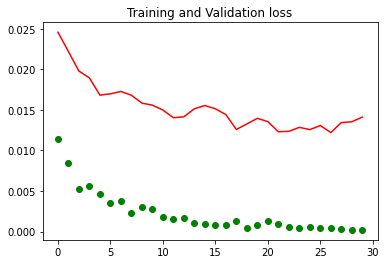

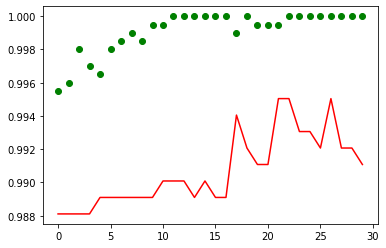

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', color='green', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and Validation loss')
plt.figure()

plt.plot(epochs, acc, 'bo', color='green', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.figure()

plt.show()

## Extracting features using data augmentation

### Define a model adding conv_base

In [ ]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### Freezing conv_base layer to prevent weight from being updated during training

In [ ]:
conv_base.trainable = False

### Training model end to end with a frozen convolutional base

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=20,
)

Found 2000 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=20,
)

Found 1010 images belonging to 2 classes.


In [ ]:
model1.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
               loss='binary_crossentropy',
               metrics=['acc'],
               )

In [ ]:
history1 = model1.fit(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_steps=51,
    )

Epoch 1/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6025 - acc: 0.6775 - val_loss: 0.4633 - val_acc: 0.8089
Epoch 2/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4809 - acc: 0.7855 - val_loss: 0.3810 - val_acc: 0.8327
Epoch 3/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4421 - acc: 0.8040 - val_loss: 0.3591 - val_acc: 0.8337
Epoch 4/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4038 - acc: 0.8285 - val_loss: 0.3216 - val_acc: 0.8634
Epoch 5/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3948 - acc: 0.8245 - val_loss: 0.3074 - val_acc: 0.8683
Epoch 6/30
100/100 [==============================] - 20s 197ms/step - loss: 0.3659 - acc: 0.8435 - val_loss: 0.3154 - val_acc: 0.8594
Epoch 7/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3679 - acc: 0.8380 - val_loss: 0.2890 - val_acc: 0.8713
Epoch 8/30
100/100 [==============================] - 2

### Visualization the result

In [ ]:
history1.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
loss1 = history1.history['loss']
acc1 = history1.history['acc']
val_loss1 = history1.history['val_loss']
val_acc1 = history1.history['val_acc']

In [ ]:
epochs1 = range(len(loss1))
epochs1

range(0, 30)

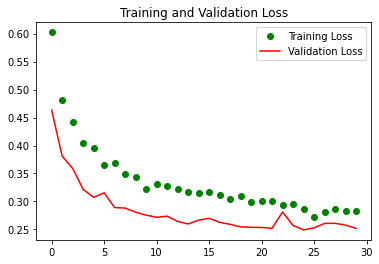

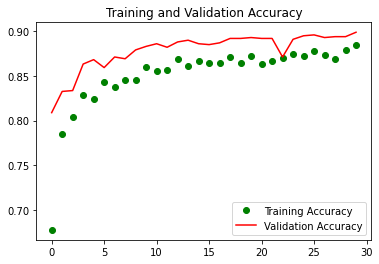

In [ ]:
plt.plot(epochs1, loss1, 'bo', color='green', label='Training Loss')
plt.plot(epochs1, val_loss1, 'b', color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs1, acc1, 'bo', color='green', label='Training Accuracy')
plt.plot(epochs1, val_acc1, 'b', color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Fine-Tuning

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Set trainable layer - Fine Tune Conv block 5

In [ ]:
conv_base.trainable=True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
len(conv_base.layers)

19

## Training model

In [ ]:
model1.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [ ]:
history2 = model1.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
)

Epoch 1/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2941 - acc: 0.8745 - val_loss: 0.2679 - val_acc: 0.8910
Epoch 2/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2560 - acc: 0.8895 - val_loss: 0.2252 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 20s 200ms/step - loss: 0.2485 - acc: 0.8895 - val_loss: 0.2061 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2143 - acc: 0.9085 - val_loss: 0.2056 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 20s 199ms/step - loss: 0.1892 - acc: 0.9195 - val_loss: 0.2039 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 20s 201ms/step - loss: 0.1923 - acc: 0.9290 - val_loss: 0.2045 - val_acc: 0.9150
Epoch 7/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1851 - acc: 0.9185 - val_loss: 0.1886 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

## Visualization the result

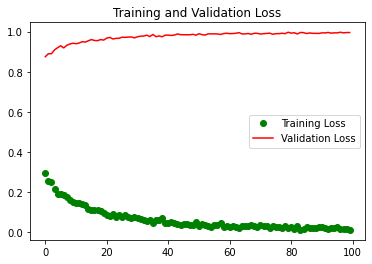

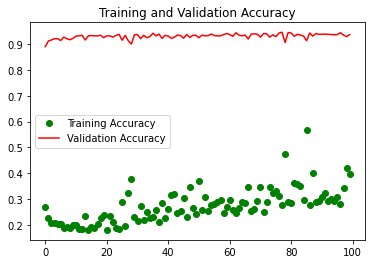

In [ ]:
loss2 = history2.history['loss']
acc2 = history2.history['acc']
val_loss2 = history2.history['val_loss']
val_acc2 = history2.history['val_acc']

epochs2 = range(len(loss2))

plt.plot(epochs2, loss2, 'bo', color='green', label='Training Loss')
plt.plot(epochs2, acc2, 'b', color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

plt.plot(epochs2, val_loss2, 'bo', color='green', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Evaluation the model

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary',
)

Found 1010 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model1.evaluate_generator(test_generator,steps=50)
test_acc

Instructions for updating:
Please use Model.evaluate, which supports generators.


0.9380000233650208

# Discovery more Data which generation from ImageDataGenerator

In [ ]:
generator = datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size
)

Found 1009 images belonging to 2 classes.


In [ ]:
generator.labels.shape

(2000,)